In [1]:
import subprocess
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RUN = 500

In [3]:
# get stdout from a terminal command
def get_stdout(command):
    return subprocess.check_output(command, shell=True).decode('utf-8')

POD_TO_NODE = {}
def get_node_of_pod(podname):
    if podname in POD_TO_NODE:
        return POD_TO_NODE[podname]
    else:
        node = get_stdout("kubectl get pod " + podname + 
                   " -o jsonpath='{.spec.nodeName}'")
        POD_TO_NODE[podname] = node
        return node

In [4]:
logfilename = f"none_CPU_{RUN}"

with open(logfilename) as f:
    lines = f.readlines()
    
rows = []    
    
for line in lines:
    
    line_json = json.loads(line.strip())
    
    cpu_util = line_json["CPUUtilizations"]
    for podname in cpu_util.keys():
        if podname == "utils":
            continue
        rows.append({
            "time": float(line_json["time"])/10**9,
            "podname": podname,
            "service": "-".join(podname.split("-")[:-1]),
            "node": get_node_of_pod(podname),
            "cpu": float(cpu_util[podname]),
        })
        
df = pd.DataFrame(rows)
df["time"] = df["time"] - df["time"].min()
# df = df[df["time"] <= 30]

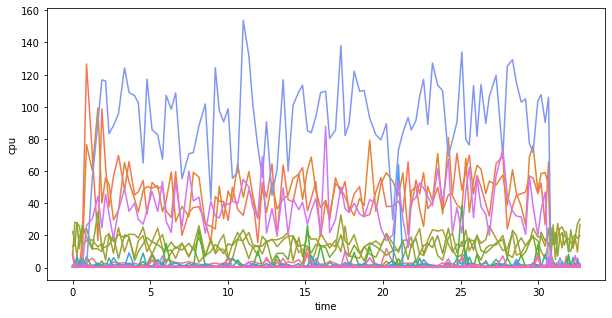

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.lineplot(ax=ax, data=df, x="time", y="cpu", hue="podname")

#remove legend from ax
ax.get_legend().remove()

In [6]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 25)].groupby(["podname", "node"]).mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,node,time,cpu
15,profile-1,minikube-m03,14.717864,92.891519
2,frontend-1,minikube-m04,14.717864,46.285842
1,frontend-0,minikube-m02,14.717864,44.662172
17,recommendation-0,minikube-m03,14.717864,38.158195
4,hostagent-node1,minikube-m02,14.717864,14.444584
5,hostagent-node2,minikube-m03,14.717864,13.986768
6,hostagent-node3,minikube-m04,14.717864,12.676689
0,consul-0,minikube-m04,14.717864,2.870419
7,jaeger-0,minikube-m04,14.717864,2.714832
11,mongodb-geo-0,minikube-m03,14.717864,1.405834


In [7]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "node"]).mean().reset_index().groupby("node").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,node,time,cpu
1,minikube-m03,130.051690,150.751701
2,minikube-m04,97.538768,66.752467
0,minikube-m02,113.795229,64.022220


In [8]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "service"]).mean().reset_index().groupby("service").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,service,time,cpu
11,profile,32.512923,95.195652
1,frontend,32.512923,91.979577
3,hostagent,48.769384,41.401256
13,recommendation,16.256461,38.468022
4,jaeger,16.256461,2.768407
0,consul,16.256461,2.747899
8,mongodb-geo,16.256461,1.347687
10,mongodb-reservation,16.256461,1.135969
9,mongodb-rate,16.256461,1.054483
16,user,16.256461,0.866104


In [9]:
df_grouped = df[df["time"] < 1].groupby("podname").mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,time,cpu
1,frontend-0,0.398428,24.141281
5,hostagent-node2,0.398428,19.973591
4,hostagent-node1,0.398428,18.813059
6,hostagent-node3,0.398428,18.578537
2,frontend-1,0.398428,14.635793
17,recommendation-0,0.398428,4.917322
0,consul-0,0.398428,3.897970
11,mongodb-geo-0,0.398428,2.521384
20,user-0,0.398428,2.204053
12,mongodb-rate-0,0.398428,2.175678
